In [1]:
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pandas as pd
from eo_flood_ops.model_utils import GroundTruthMeasurement
from eo_flood_ops.thresholding_model import ThresholdingModel
from eo_flood_ops.general_utils import tif_to_clipped_masked_array, find_closest_valid, generate_timeseries_ds

class MyGroundTruthMeasurement(GroundTruthMeasurement):
  pass



In [3]:
images_dir = R"p:\11211461-010--eo-flood-ops\Sava\classified_events"
aoi_dir = R"p:\11211461-010--eo-flood-ops\Sava\AOI_obs_based"
waterlevels_fn = R"p:\11211461-010--eo-flood-ops\Sava\water_levels\Sava_Bosna_gauges_H_20190101_20250430.csv"
dem_fn = R"p:\11211461-010--eo-flood-ops\Sava\DEMs\bosna_FABDEM.tif"

In [4]:
df_water = pd.read_csv(waterlevels_fn, skiprows=[1])
df_water.rename(columns={df_water.columns[0]: "datetime"}, inplace=True)
df_water["datetime"] = pd.to_datetime(df_water["datetime"])

results_per_aoi = {}

# Loop over AOI files
for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    if aoi_name == "Modrica":
        continue
    print(f"Processing AOI: {aoi_name}")
    print("*" * 45)
    # Store image-water level tuples
    image_water_levels = []
    
    # Loop over images
    for image_name in os.listdir(images_dir):
        if not image_name.endswith(".tif"):
            continue
        

        datetime_str = image_name.split("_")[1].replace(".tif", "") 
        dt = datetime.strptime(datetime_str, "%Y%m%dT%H%M%S")
        dt = pd.Timestamp(dt)
        dt_gmt1 = dt + pd.Timedelta(hours=1)  # Convert to GMT+1

        closest_time, value = find_closest_valid(df_water, dt_gmt1, aoi_name)
        
        if closest_time is not None:
            print(f"Image: {image_name}")
            print(f"Image timestamp (GMT+1): {dt_gmt1}")
            print("Closest valid timestamp:", closest_time)
            print(f"{aoi_name} value:", value)
            print("=" * 45)
            image_water_levels.append((image_name, value))
        else:
            print(f"No valid {aoi_name} values found in dataset for image {image_name}.")

    if not image_water_levels:
        print(f"No images found for AOI: {aoi_name}")
        continue

    # print some spacing to improve readability
    print("\n" * 1)

    # Sort by water level ascending
    image_water_levels.sort(key=lambda x: x[1])
    
    # Store results
    results_per_aoi[aoi_name] = image_water_levels

Processing AOI: Raspotocje
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Raspotocje value: 2.57
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+1): 2021-11-07 05:54:15
Closest valid timestamp: 2021-11-07 06:00:00
Raspotocje value: 2.79


Processing AOI: Kakanj nB
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Kakanj nB value: 2.89
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+1): 2021-11-07 05:54:15
Closest valid timestamp: 2021-11-07 06:00:00
Kakanj nB value: 3.38


Processing AOI: Ljubnici
*********************************************
Image: Bosna_20190204T164100.tif
Image timestamp (GMT+1): 2019-02-04 17:41:00
Closest valid timestamp: 2019-02-04 18:00:00
Ljubnici value: 2.03
Image: Bosna_20211107T045415.tif
Image timestamp (GMT+

In [5]:
# Prepare GROUND TRUTH for each AOI

# Dictionary to store GROUND_TRUTH per AOI
GROUND_TRUTH_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    if aoi_name == "Modrica":  # skip for now
        continue
    
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Make sure we have results for this AOI
    if aoi_name not in results_per_aoi:
        print(f"No images found for AOI: {aoi_name}")
        continue
    
    GROUND_TRUTH = []
    
    for image_name, water_level in results_per_aoi[aoi_name]:
        image_path = os.path.join(images_dir, image_name)
        
        masked_array, transforms, crs = tif_to_clipped_masked_array(
            image_path,
            aoi_fn,
        )
        
        GROUND_TRUTH.append(MyGroundTruthMeasurement(
            ground_truth=masked_array,
            gauge_measurement=water_level
        ))
    
    # Store per AOI
    GROUND_TRUTH_per_aoi[aoi_name] = GROUND_TRUTH

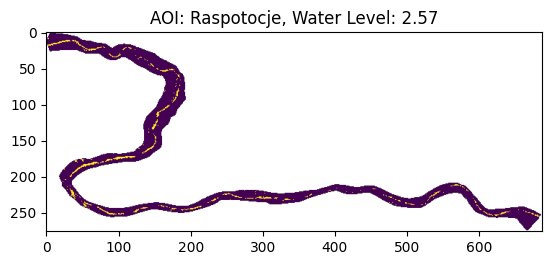

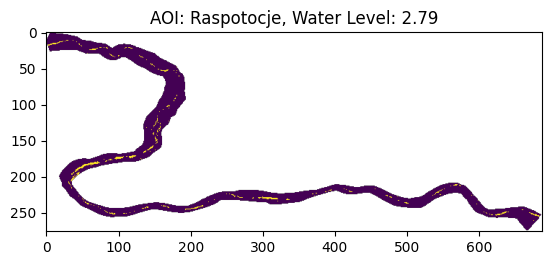

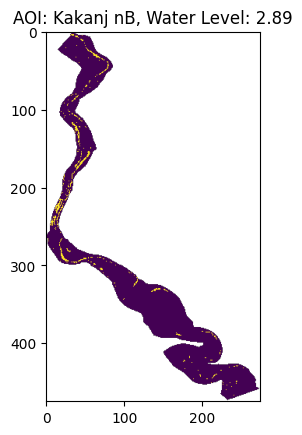

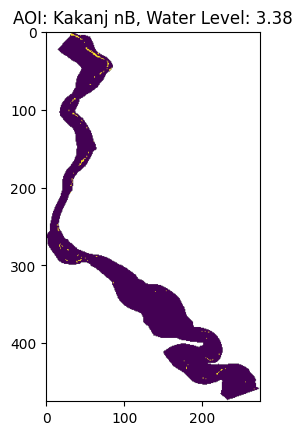

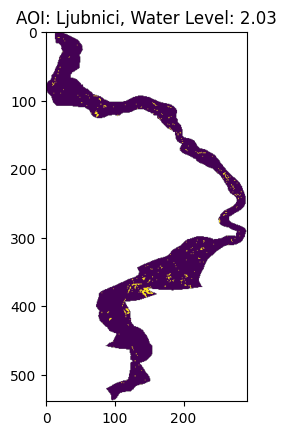

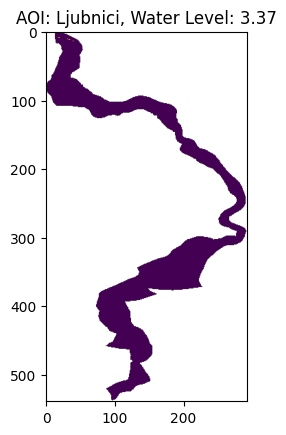

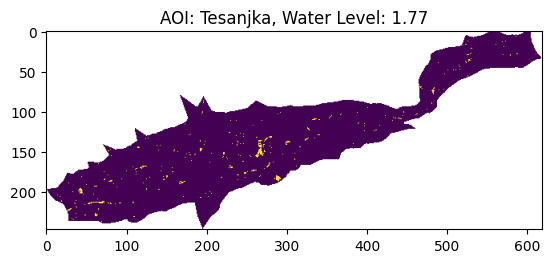

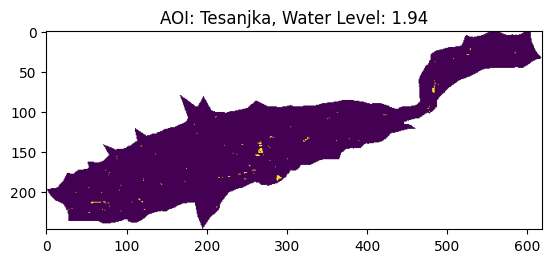

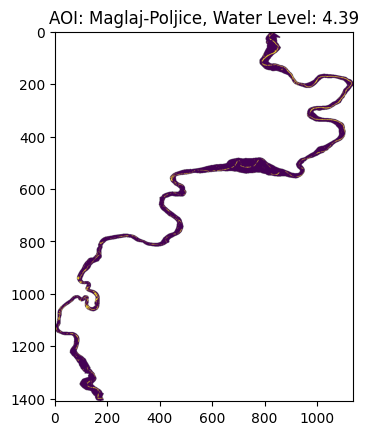

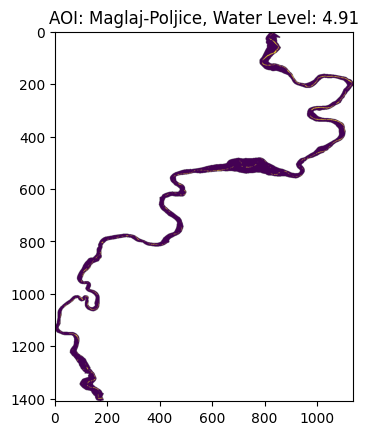

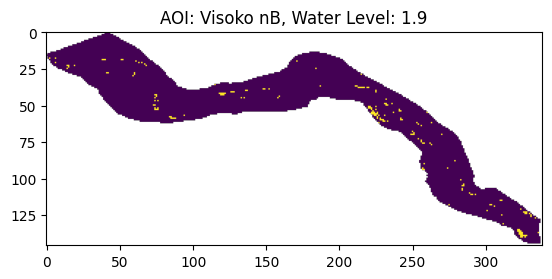

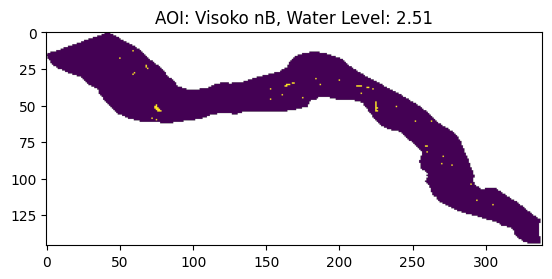

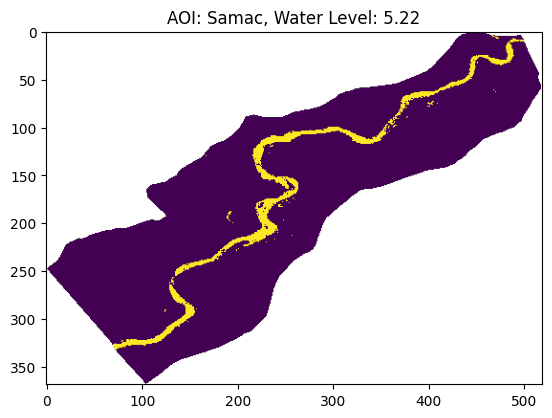

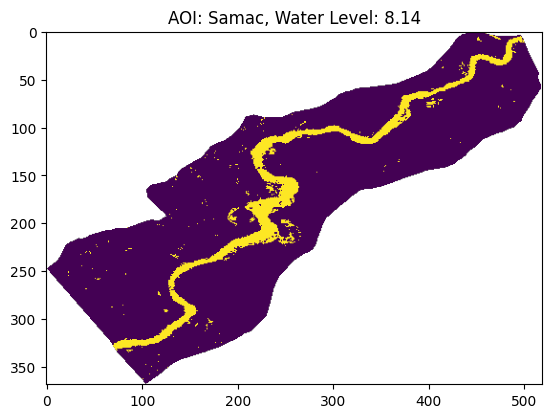

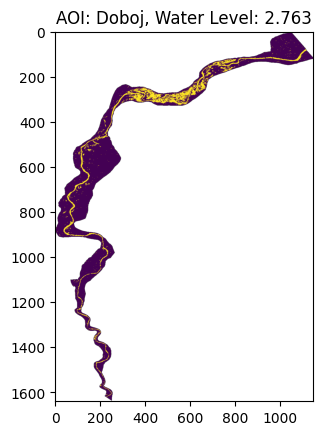

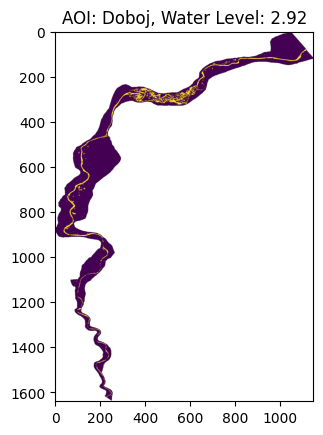

In [6]:
for aoi in results_per_aoi:
    for gt in GROUND_TRUTH_per_aoi[aoi]:
        plt.imshow(gt.ground_truth)
        plt.title(f"AOI: {aoi}, Water Level: {gt.gauge_measurement}")
        plt.show()

### Thresholding 

In [7]:
# MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]
MIN_RATIOS = [0.1, 1]

trained_models_tm= {}

for aoi_name, GROUND_TRUTH in GROUND_TRUTH_per_aoi.items():
    print("\n" + "="*60)
    print(f"Starting training for AOI: {aoi_name}")
    print(f"Number of ground truth images: {len(GROUND_TRUTH)}")
    print(f"Using minimum ratios: {MIN_RATIOS}")
    
    tm = ThresholdingModel()
    
    tm.train(
        minumum_ratios=MIN_RATIOS,
        ground_truth=GROUND_TRUTH
    )
    
    trained_models_tm[aoi_name] = tm
    print(f"Finished training for AOI: {aoi_name}")
    print("="*60)



Starting training for AOI: Raspotocje
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]


C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets
C:\Users\tsiokano\git\EO-Flood-Ops\src\eo_flood_ops\model_utils.py:251: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.8394552208006603
For min_ratio=1 we get f1=0.8394552208006603
chosen min_ratio 1
Finished training for AOI: Raspotocje

Starting training for AOI: Kakanj nB
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.7561683599419448
For min_ratio=1 we get f1=0.7561683599419448
chosen min_ratio 1
Finished training for AOI: Kakanj nB

Starting training for AOI: Ljubnici
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.6693266832917705
For min_ratio=1 we get f1=0.6693266832917705
chosen min_ratio 1
Finished training for AOI: Ljubnici

Starting training for AOI: Tesanjka
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]
For min_ratio=0.1 we get f1=0.775055679287305
For min_ratio=1 we get f1=0.775055679287305
chosen min_ratio 1
Finished training for AOI: Tesanjka

Starting training for AOI: Maglaj-Poljice
Number of ground truth images: 2
Using minimum ratios: [0.1, 1]


In [10]:
trained_models_tm

{'Raspotocje': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3fb37a10>,
 'Kakanj nB': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3fb6d790>,
 'Ljubnici': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3df3de80>,
 'Tesanjka': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3df3e030>,
 'Maglaj-Poljice': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e331ba3c0>,
 'Visoko nB': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3df3c650>,
 'Samac': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3fac5880>,
 'Doboj': <eo_flood_ops.thresholding_model.ThresholdingModel at 0x25e3fac7ec0>}

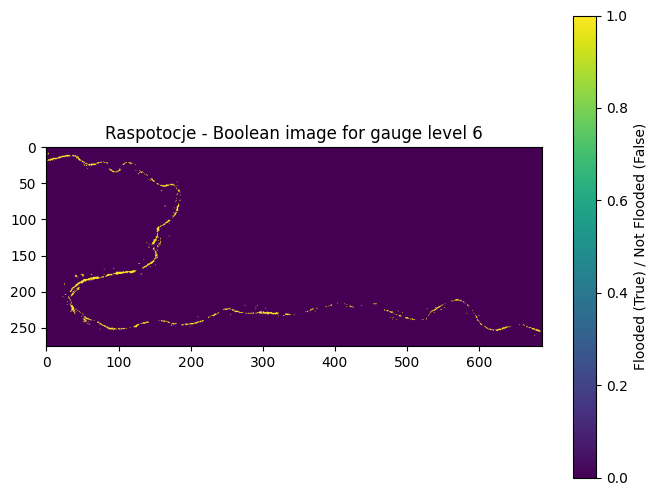

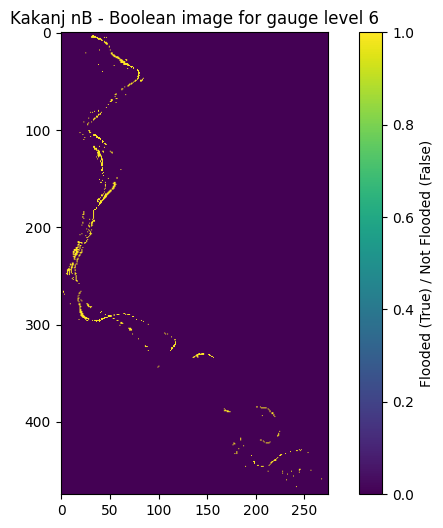

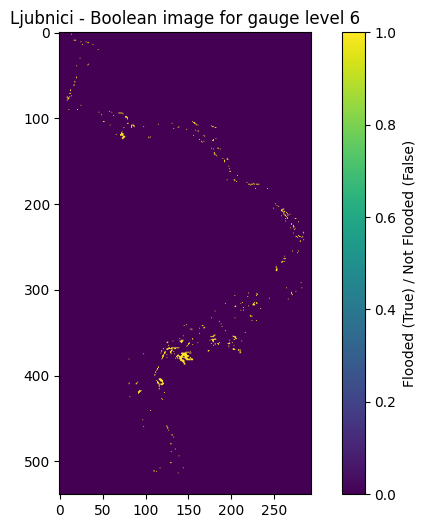

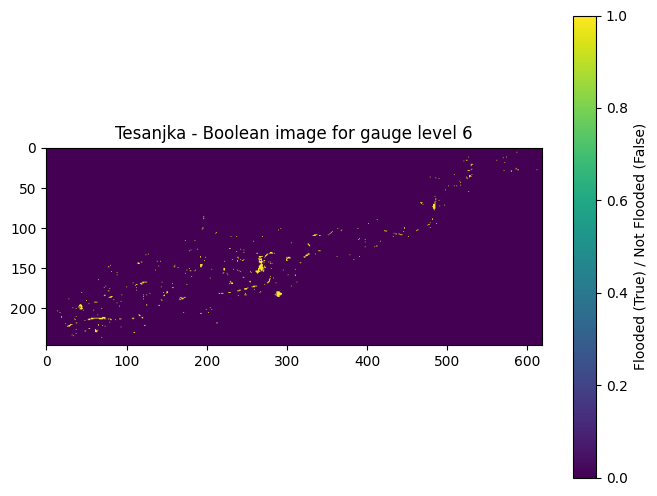

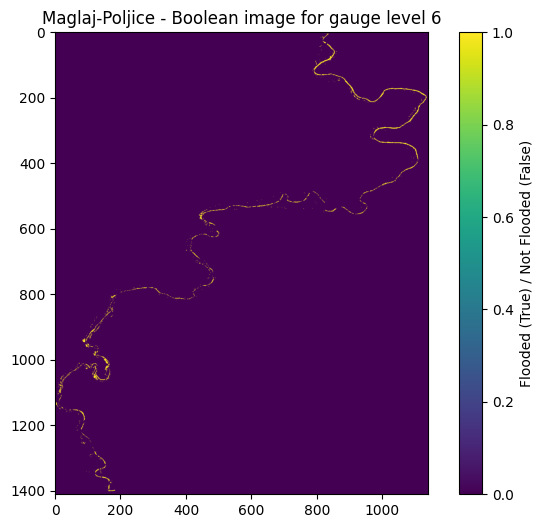

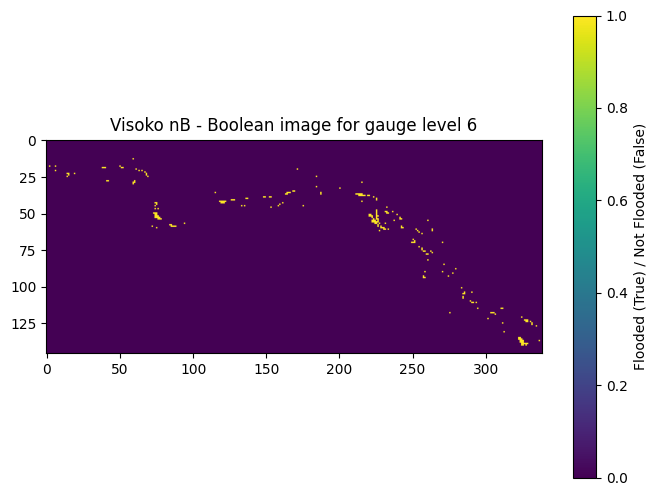

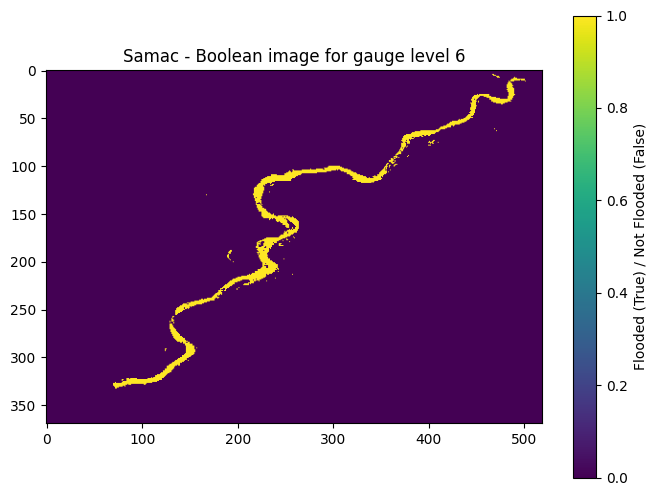

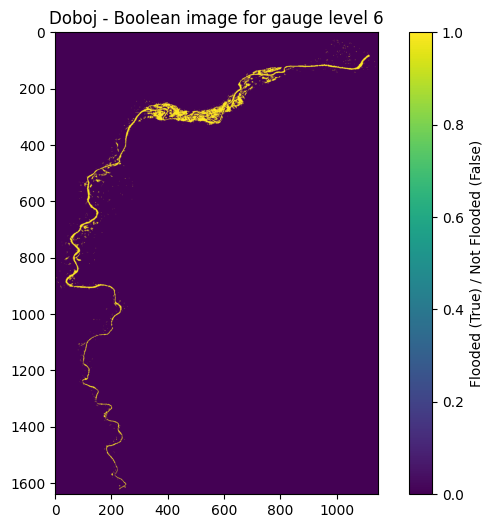

In [11]:
# Example gauge levels to test
gauge_levels = [6]

# Loop over all AOIs and trained models
for aoi_name, tm in trained_models_tm.items():
    for gauge_level in gauge_levels:
        plt.figure(figsize=(8, 6))
        plt.title(f'{aoi_name} - Boolean image for gauge level {gauge_level}')
        plt.imshow(tm.infer(gauge_level))  # Boolean images are usually better in gray
        plt.colorbar(label='Flooded (True) / Not Flooded (False)')
        plt.show()

### Manifold 

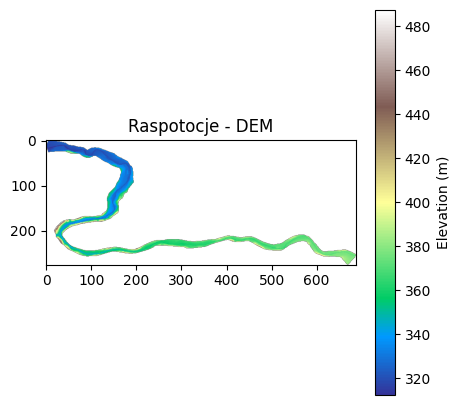

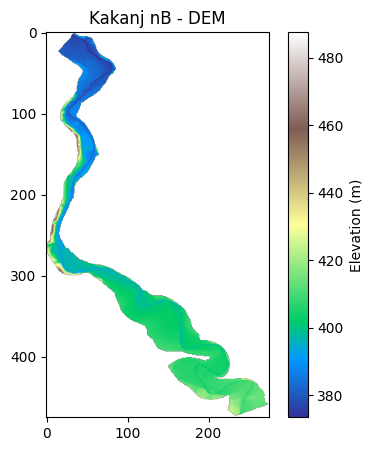

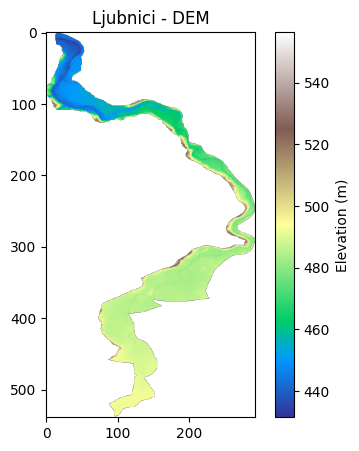

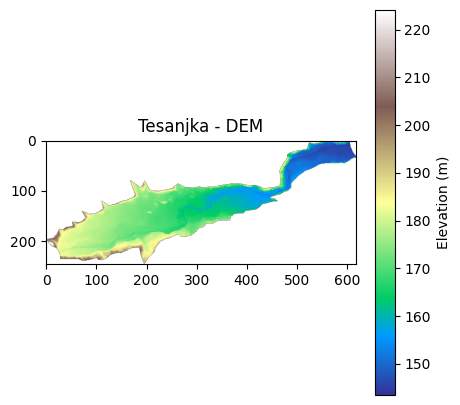

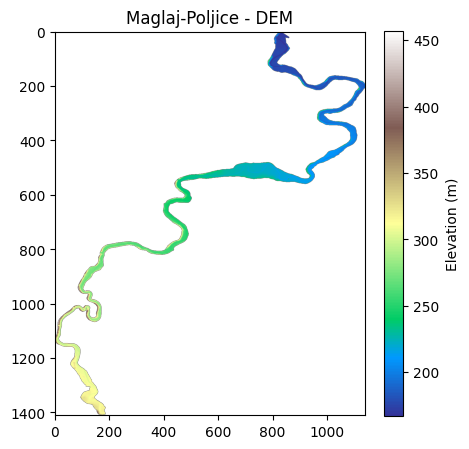

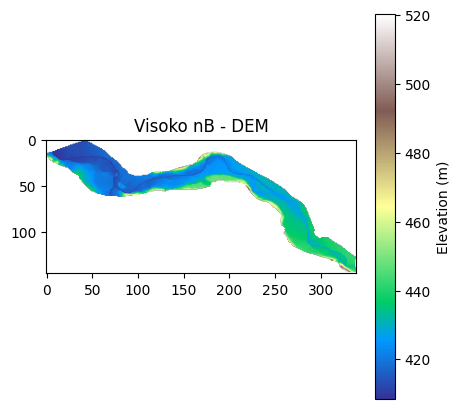

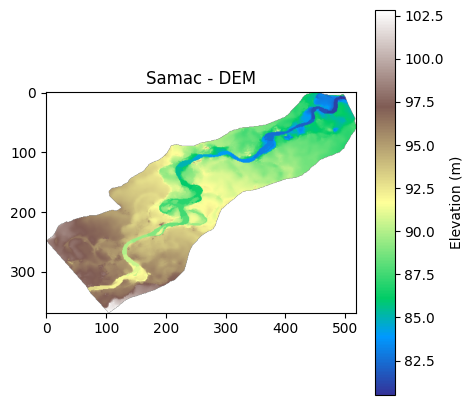

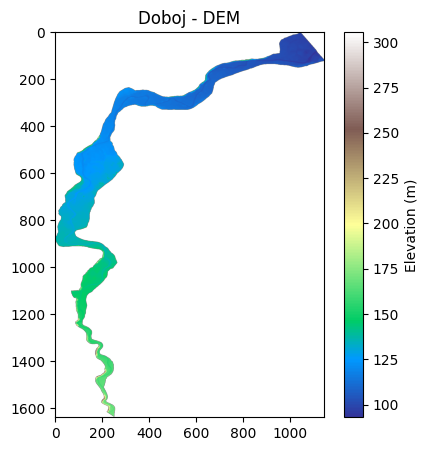

In [12]:
DEM_per_aoi = {}

for aoi_file in os.listdir(aoi_dir):
    if not aoi_file.endswith('.geojson'):
        continue
    if aoi_file.split('_')[1].split('.')[0] == "Modrica":  # skip for now
        continue
    
    aoi_name = aoi_file.split('_')[1].split('.')[0]
    aoi_fn = os.path.join(aoi_dir, aoi_file)
    
    # Clip DEM for this AOI
    DEM, dem_transform, dem_crs = tif_to_clipped_array(dem_fn, aoi_fn)
    
    # Store in a dictionary
    DEM_per_aoi[aoi_name] = {
        'DEM': DEM,
        'transform': dem_transform,
        'crs': dem_crs
    }
    
    # Optional: quick visualization
    plt.figure(figsize=(5, 5))
    plt.title(f'{aoi_name} - DEM')
    plt.imshow(DEM, cmap='terrain')
    plt.colorbar(label='Elevation (m)')
    plt.show()
    

Training a Manifold model at the correct data resolution will give an error in the coarse water resolution map (cotnours etc), thus, we will stop here

In [ ]:
# Generate time series datasets for each AOI using the trained thresholding models
gauge_levels = [1, 6, 7.5, 3.2, 10]
timestamps = pd.date_range("2020-01-01", periods=len(gauge_levels), freq="7D")

ds_per_aoi = {}  # dict to store datasets

for aoi_name, trained_model in trained_models_tm.items():    
    transform = DEM_per_aoi[aoi_name]['transform']
    crs = DEM_per_aoi[aoi_name]['crs']

    # Generate the Dataset for this AOI
    ds_threshold = generate_timeseries_ds(
        water_levels=gauge_levels,
        timestamps=timestamps,
        tm=trained_model,
        transform=transform,
        crs=crs
    )

    # Store in the dictionary
    ds_per_aoi[aoi_name] = ds_threshold

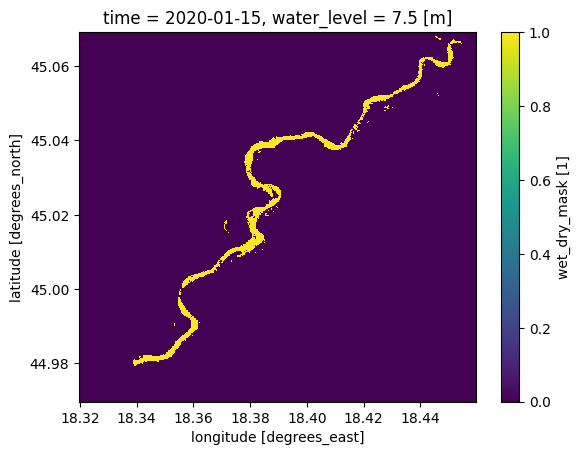

In [17]:
ds_per_aoi["Samac"]["wet_dry"].sel(time="2020-01-15").plot()